In [5]:
import locmofitpy2
import pandas as pd

locs_df = pd.read_csv("data/simulated_data_spcap.csv")
locs = locs_df.values[:, 0:3]
stddev = locs_df.values[:, 3:]

In [6]:
# %%timeit
res = locmofitpy2.run_locmofit("SphericalCap", locs, stddev, seed=3, freeze=(), max_iter=200, tol=1e-6)

In [7]:
print(res["final_loss"], res["iters"])

253.7626953125 200.0


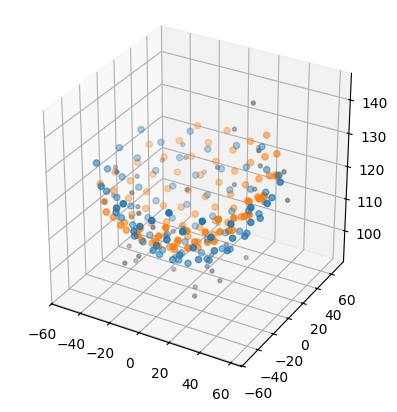

In [9]:
import numpy as np
import matplotlib.pyplot as plt

ground_truth = pd.read_csv("data/ground_truth_spcap.csv")

positions = np.array(res["model_points"])  # converts JAX array -> NumPy array on host

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.set_box_aspect((1, 1, 1))
ax.scatter(locs_df["x"], locs_df["y"], locs_df["z"], c="gray", s=8)  # type: ignore[arg-type]
ax.scatter(ground_truth["x"], ground_truth["y"], ground_truth["z"])  # type: ignore[arg-type]
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2])  # type: ignore[arg-type]

plt.show()
